In [1]:
# !curl ipecho.net/plain
# !pip install pymfe
# !pip install mysql-connector

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import mysql.connector

# mydb = mysql.connector.connect(
#   host="localhost",
#   user="root",
#   passwd="",
#   database="anomaly_detection_decision_support"
# )

# mycursor = mydb.cursor()


def open_connection():
    mydb = mysql.connector.connect(
      host="34.68.13.182",
      user="root",
      passwd="6g8HBIy0F8atEKtb",
      database="anomaly_detection_decision_support"
    )

    mycursor = mydb.cursor()
    return mydb, mycursor

def close_connection(mydb, mycursor):
    mycursor.close()
    mydb.close()

In [4]:
import os
import json
import mysql.connector


def get_datasets(path):
    datasets = []
    for root, dirs, files in os.walk(path):
        for dir in dirs:
            with open(os.path.join(root, dir, 'metadata.json')) as json_file:
                metadata = json.load(json_file)
                metadata['files'] = [os.path.join(root, dir, filename) for filename in metadata['files']]
                datasets.append(metadata)
    return datasets

def get_methods():
    methods = [
        {
            'name': 'gaussian',
            'parameters': {},
            'isSupervised': False,
        }, {
            'name': 'linear_regression',
            'parameters': {},
            'isSupervised': False,
        }, {
            'name': 'pca',
            'parameters': {},
            'isSupervised': False,
        }, {
            'name': 'kmeans',
            'parameters': {},
            'isSupervised': False,
        }, {
            'name': 'neural_network',
            'parameters': {},
            'isSupervised': True,
        }
    ];
    
    return methods
                       

In [5]:
#initialize tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

strategy = None
if (os.environ.get('COLAB_TPU_ADDR')!=None):
  os.environ['TPU_ADDR'] = os.environ['COLAB_TPU_ADDR']
# else:
#   os.environ['TPU_ADDR'] = '10.15.20.26:8470'

if (os.environ.get('TPU_ADDR')!=None):
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)

def get_devices():
    if strategy:
        devices = ['ASIC']
    else:
        devices = [d.name for d in device_lib.list_local_devices() if 'XLA' not in d.name]
    return devices

In [6]:
# data cleansing
import numpy as np
import pandas as pd
from pymfe.mfe import MFE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def transform_data(dataset, rows = 1000, mfe = True):
    # read data from files
    df = pd.DataFrame()
    chunk = int(rows/len(dataset['files']))
    for filename in dataset['files']:
        if chunk == 0:
          df_temp = pd.read_csv(filename, error_bad_lines=False, warn_bad_lines=False,index_col=None)
        else:
          df_temp = pd.read_csv(filename, error_bad_lines=False, warn_bad_lines=False,index_col=None, nrows=chunk)
        if df.columns.size != 0:
            df_temp.columns=df.columns
        df = pd.concat([df, df_temp], axis=0)

    # convert objects to category codes
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            df[col_name]= df[col_name].astype('category')
            df[col_name] = df[col_name].cat.codes.astype('int64')
            
    # split dataset into features and target arrays
    features = target = feature_scores = None
    if (dataset['label']):
        features = np.nan_to_num(df.drop(columns=[dataset['label']]).to_numpy())
        target = df[dataset['label']].to_numpy()
    else:
        features = df.to_numpy()
        
    # features selection
    if (dataset['label']):
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(features, target)
        feature_scores = pd.DataFrame(np.vstack([clf.feature_importances_]), 
                                      columns=df.drop(columns=[dataset['label']]).columns.values).to_dict(orient='records')[0]

    
    # standardize dataset
    scaler = preprocessing.StandardScaler()
    features = scaler.fit_transform(features)
    features = np.nan_to_num(features)
#     features = preprocessing.scale(features)    
    
    # Extract general, statistical and information-theoretic measures
    ft = ()
    if mfe==True:
        mfe = MFE(groups=["general", "statistical", "info-theory"],suppress_warnings = True)
        if dataset['label']:
            mfe.fit(features, target)
        else:
            mfe.fit(features)
        ft = mfe.extract()
        ft = np.nan_to_num(ft)
    
    return features, target, feature_scores, ft

In [7]:
import tensorflow_probability as tfp

def gaussian(features):
    
    # measure training time
    start_time = tf.timestamp()
    features = tf.constant(features)
    mu = tf.reduce_mean(features, axis=0)
    mu = tf.reshape(mu, [1,features.shape[1]])
    mx = tf.matmul(tf.transpose(mu), mu)
    vx = tf.matmul(tf.transpose(features), features)/tf.cast(tf.shape(features)[0], tf.float64)
    sigma = vx - mx
#     mvn = tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=tf.linalg.cholesky(sigma))
    train_time = tf.timestamp()-start_time
    # measure test time
    start_time = tf.timestamp()
#     mvn.prob(tf.constant(features))
    test_time = (tf.timestamp()-start_time)/features.shape[0]
    
    return train_time.numpy(), test_time.numpy() 

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def linear(features):
    # create linear regression
    model = Sequential()
    model.add(Dense(1, input_dim=features.shape[1], activation='linear'))
    
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop(0.001),
                metrics=['mean_absolute_error', 'mean_squared_error'])
    
    # measure training time
    start_time = tf.timestamp()
    model.fit(features,features)
    train_time = tf.timestamp()-start_time
    
    weights = tf.transpose(model.get_weights()[0])
    
    # measure test time
    start_time = tf.timestamp()
    distance = tf.math.divide(tf.math.abs(tf.math.add(tf.reduce_sum(tf.multiply(weights, features), axis=1),model.get_weights()[1])),
                              tf.math.sqrt(tf.reduce_sum(tf.multiply(weights, weights), axis=1)))
    test_time = (tf.timestamp()-start_time)/features.shape[0]
    
    return train_time.numpy(), test_time.numpy()
    

In [9]:
def pca(features):
    features -= tf.reduce_mean(features, axis=0)
    
    start_time = tf.timestamp()
    result = tf.linalg.svd(features)
    train_time = test_time = (tf.timestamp()-start_time)
    
    return train_time.numpy(), test_time.numpy()

In [10]:
# function which returns data (necessary for tensorflow v1)
def input_fn():
    return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(features, dtype=tf.float32), num_epochs=1)


def kmeans(features):
    # build a model
    model = tf.compat.v1.estimator.experimental.KMeans(5)
    
    #train a model
    start_time = tf.timestamp()
    model.train(input_fn)
    train_time = (tf.timestamp()-start_time)
    
    #test a model
    start_time = tf.timestamp()
    model.predict_cluster_index(input_fn)
    test_time = (tf.timestamp()-start_time)
    
    return train_time.numpy(), test_time.numpy()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def nn(features, target):
    # create a NN
    model = Sequential()
    model.add(Dense(features.shape[1], input_dim=features.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # build a model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Accuracy()
    ])
    
    # measure training time
    start_time = tf.timestamp()
    model.fit(features, target)
    train_time = tf.timestamp()-start_time
    
    # measure test time
    start_time = tf.timestamp()
    results = model.predict(features)
    test_time = (tf.timestamp()-start_time)/features.shape[0]
    
    # cross validation
    validation = model.evaluate(features, target)
    
    return train_time.numpy(), test_time.numpy(), validation
    

In [12]:
def evaluate(device, methods, dataset, features, target):
    isSupervised = target is not None
    for method in methods:
        if method['isSupervised'] == isSupervised:
            if method['name'] == 'gaussian':
                result = gaussian(features)
            elif method['name'] == 'linear_regression':
                result = linear(features)
            elif method['name'] == 'pca':
                result = pca(features)
            elif method['name'] == 'kmeans':
                result = kmeans(features)
            elif method['name'] == 'neural_network':
                result = nn(features, target)
                
            print('Running',method['name'])
            print(device, method, dataset['name'], result)
#             insert_evaluation_info(device, method, dataset, result)

In [32]:
def clear_db():
    mydb, mycursor = open_connection()
    mycursor.execute('DELETE FROM algorithm')
    mydb.commit()
    sql = "INSERT INTO algorithm (name, complexity) VALUES (%s, %s)"
    val = ('gaussian', 'O(n^2)')
    mycursor.execute(sql, val)
    val = ('linear_regression', 'O(n^2)')
    mycursor.execute(sql, val)
    val = ('pca', 'O(n^2)')
    mycursor.execute(sql, val)
    val = ('kmeans', 'O(n^2)')
    mycursor.execute(sql, val)
    val = ('neural_network', 'O(n^2)')
    mycursor.execute(sql, val)
    
    mydb.commit()

    mycursor.execute('DELETE FROM device_characterization')
    mycursor.execute('DELETE FROM device')

    sql = "INSERT INTO device (name, type) VALUES (%s, %s)"
    val = ('Intel Xeon', 'CPU')
    mycursor.execute(sql, val)
    
    device_id = mycursor.lastrowid
    sql = "INSERT INTO device_characterization (device_id, name, value) VALUES (%s, %s, %s)"
    val = (device_id, 'transistor_count', '7.2')
    mycursor.execute(sql, val)
    val = (device_id, 'core_count', '2')
    mycursor.execute(sql, val)
    val = (device_id, 'technology', '22')
    mycursor.execute(sql, val)
    val = (device_id, 'power_dissipation', '180')
    mycursor.execute(sql, val)
    val = (device_id, 'flops', '90')
    mycursor.execute(sql, val)
    val = (device_id, 'fequency', '4300')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_type', 'DRAM')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_size', '13')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_bandwidth', '')
    mycursor.execute(sql, val)
    val = (device_id, 'weight', '')
    mycursor.execute(sql, val)

    sql = "INSERT INTO device (name, type) VALUES (%s, %s)"
    val = ('Tesla K80', 'GPU')
    mycursor.execute(sql, val)
    device_id = mycursor.lastrowid
    sql = "INSERT INTO device_characterization (device_id, name, value) VALUES (%s, %s, %s)"
    val = (device_id, 'transistor_count', '7.1')
    mycursor.execute(sql, val)
    val = (device_id, 'core_count', '2496')
    mycursor.execute(sql, val)
    val = (device_id, 'technology', '28')
    mycursor.execute(sql, val)
    val = (device_id, 'power_dissipation', '300')
    mycursor.execute(sql, val)
    val = (device_id, 'flops', '2910')
    mycursor.execute(sql, val)
    val = (device_id, 'fequency', '1562')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_type', 'DRAM')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_size', '12')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_bandwidth', '')
    mycursor.execute(sql, val)
    val = (device_id, 'weight', '')
    mycursor.execute(sql, val)

    sql = "INSERT INTO device (name, type) VALUES (%s, %s)"
    val = ('Google TPU', 'ASIC')
    mycursor.execute(sql, val)
    device_id = mycursor.lastrowid
    sql = "INSERT INTO device_characterization (device_id, name, value) VALUES (%s, %s, %s)"
    val = (device_id, 'transistor_count', '2.1')
    mycursor.execute(sql, val)
    val = (device_id, 'core_count', '2496')
    mycursor.execute(sql, val)
    val = (device_id, 'technology', '28')
    mycursor.execute(sql, val)
    val = (device_id, 'power_dissipation', '40')
    mycursor.execute(sql, val)
    val = (device_id, 'flops', '180000')
    mycursor.execute(sql, val)
    val = (device_id, 'fequency', '700')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_type', 'SRAM')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_size', '16')
    mycursor.execute(sql, val)
    val = (device_id, 'memory_bandwidth', '')
    mycursor.execute(sql, val)
    val = (device_id, 'weight', '')
    mycursor.execute(sql, val)
    mydb.commit()

    mycursor.execute('DELETE FROM dataset_characterization')
    mycursor.execute('DELETE FROM feature_score')
    mycursor.execute('DELETE FROM dataset')
    
    
    mycursor.execute('DELETE FROM performance')
    mycursor.execute('DELETE FROM parameter')
    mycursor.execute('DELETE FROM evaluation')
    
    mydb.commit()
    
    close_connection(mydb, mycursor)
    
def insert_data_info(dataset, feature_score, ft):
    mydb, mycursor = open_connection()
    mycursor.execute("SELECT * FROM dataset WHERE name='"+str(dataset['name'])+"'")
    row = mycursor.fetchone()
    if row:
        return row[0]
    
    sql = "INSERT INTO dataset (name, type_of_data, domain, anomaly_types, anomaly_space, anomaly_entropy, label, files) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
    val = (dataset['name'], str(dataset['type_of_data']).strip('[]'), str(dataset['domain']).strip('[]'), str(dataset['anomaly_types']).strip('[]'), dataset['anomaly_space'], dataset['anomaly_entropy'], dataset['label'], str(dataset['files']).strip('[]'))
    mycursor.execute(sql, val)
    mydb.commit()
    dataset['id'] = mycursor.lastrowid;
    
    if len(ft) == 2:
        for i in range(len(ft[0])):
            sql = "INSERT INTO dataset_characterization (dataset_id, name, value) VALUES (%s, %s, %s)"
            val = (dataset['id'], str(ft[0][i]), str(ft[1][i]))
            mycursor.execute(sql, val)
        mydb.commit()
        
    if feature_score:
        for key in feature_score:
            sql = "INSERT INTO feature_score (dataset_id, name, value) VALUES (%s, %s, %s)"
            val = (dataset['id'], str(key), str(feature_score[key]))
            mycursor.execute(sql, val)
        mydb.commit()
        
    close_connection(mydb, mycursor)
    return dataset['id']


def insert_evaluation_info(device, method, dataset, result):
    device_type = 'ASIC'
    if 'CPU' in device:
        device_type = 'CPU'
    elif 'GPU' in device:
        device_type = 'GPU'
        
    mydb, mycursor = open_connection()
    mycursor.execute("SELECT * FROM device WHERE type='"+device_type+"'")
    device_id = mycursor.fetchone()[0]
    mycursor.execute("SELECT * FROM dataset WHERE id="+str(dataset['id']))
    dataset_id = mycursor.fetchone()[0]
    mycursor.execute("SELECT * FROM algorithm WHERE name='"+method['name']+"'")
    algorithm_id = mycursor.fetchone()[0]

    sql = "INSERT INTO evaluation (evaluation_id, dataset_id, algorithm_id, device_id, training_time, inference_time) VALUES (%s, %s, %s, %s, %s, %s)"
    val = (1, dataset_id, algorithm_id, device_id, str(result[0]), str(result[1]))
    mycursor.execute(sql, val)
    mydb.commit()

    if len(result) == 3:
        evaluation_id = mycursor.lastrowid;
        sql = "INSERT INTO performance (evaluation_id, name, value) VALUES (%s, %s, %s)"
        val = (evaluation_id, 'mean_squared_error', str(result[2][0]))
        mycursor.execute(sql, val)
        val = (evaluation_id, 'auc', str(result[2][0]))
        mycursor.execute(sql, val)
        val = (evaluation_id, 'precision', str(result[2][1]))
        mycursor.execute(sql, val)
        val = (evaluation_id, 'recall', str(result[2][2]))
        mycursor.execute(sql, val)
        val = (evaluation_id, 'accuracy', str(result[2][3]))
        mycursor.execute(sql, val)
        mydb.commit()
        
    close_connection(mydb, mycursor)
    
    

def get_evaluation_info():
    mydb, mycursor = open_connection()
    
    evaluation_query = """select a.name, d.name, dev.name, e.training_time, e.inference_time, 
(select value*e.training_time/3600 from device_characterization dev_char where dev_char.device_id = dev.id and name = 'power_dissipation' limit 1) as training_power_dissipation,
(select value*e.inference_time/3600 from device_characterization dev_char where dev_char.device_id = dev.id and name = 'power_dissipation' limit 1) as inference_power_dissipation
from evaluation e
inner join algorithm a on e.algorithm_id = a.id
inner join dataset d on e.dataset_id = d.id
inner join device dev on e.device_id = dev.id
where a.name = 'linear_regression' or a.name = 'neural_network'
""";
    mycursor.execute(evaluation_query)
    result = mycursor.fetchall()
    
    close_connection(mydb, mycursor)
    
    return result

In [29]:
# clear_db()

In [ ]:
local_gdrive = '../GoogleDrive'
remote_gdrive = '/content/drive/My Drive'

datasets = get_datasets(local_gdrive+'/Academic/PhD/III/datasets/')
devices = get_devices()
methods = get_methods()

# tf.profiler.experimental.start('logdir')

print('*** Datasets for evaluation:', len(datasets),'***')
i = 1
for dataset in datasets:
    try:
        print('*** Dataset:',i,'Name:',dataset['name'])
        i+=1
        features, target, feature_score, ft = transform_data(dataset, 0, False)
#         dataset['id'] = insert_data_info(dataset, feature_score, ft)
        print('Features:', features.shape)

#         for device in devices:
#             if device == 'ASIC':
#                 with strategy.scope():
#                     evaluate(device, methods, dataset, features, target)
#             else:
#                 with tf.device(device):
#                     evaluate(device, methods, dataset, features, target)
        
    except Exception as e:
        print(e)
print('*** DONE ***')

# tf.profiler.experimental.stop()
    
    
    

*** Datasets for evaluation: 15 ***
*** Dataset: 1 Name: Green Card & H1B (2014-2018)
Features: (67179, 27)
*** Dataset: 2 Name: Software Operational Data
Features: (439873, 234)
*** Dataset: 3 Name: Bike Share Daily Data
Features: (17379, 17)
*** Dataset: 4 Name: Australian Centre for Cyber Security


 * Warning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
 * Warning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.


Features: (2540044, 48)
*** Dataset: 5 Name: Spacecraft Anomaly Data
Features: (4654, 20)
*** Dataset: 6 Name: High Storage System Data for Energy Optimization
Features: (23645, 19)
*** Dataset: 7 Name: IoT Botnet Attacks
Features: (468393, 115)
*** Dataset: 8 Name: Breast Cancer Diagnostic
Features: (367, 30)
*** Dataset: 9 Name: Predicting Reddit Community Engagement Dataset
Features: (425548, 11)
*** Dataset: 10 Name: Genesis demonstrator data for machine learning
Features: (32440, 19)
*** Dataset: 11 Name: Bitcoin Network Transactional Metadat


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=./logdir

Visualsualization

In [33]:
result = get_evaluation_info()
result = pd.DataFrame(result, columns =['algorithm', 'dataset', 'architecture', 'train_time', 'inference_time','train_power', 'inference_power']) 
result['train_time'] = pd.to_numeric(result['train_time'])
result['inference_time'] = pd.to_numeric(result['inference_time'])

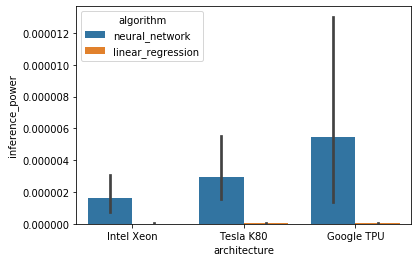

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import datetime

interactive(True)


# cats_group=result[["dataset","algorithm"]]
# cats_group = cats_group.groupby(["dataset","algorithm"])
# cats_group = cats_group.size().unstack()

sns.barplot(x="architecture", y="inference_power", hue="algorithm", data=result)
# cats_group.plot(result['algorithm'].to_numpy(), result['inference_time'])


# f, (dogs_chart) = plt.subplots(1, 1)
# sns.countplot(x=result['dataset'], ax=dogs_chart)
# dogs_chart.set_title('Dogs')